In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns;
sns.set(style="white", color_codes=True)
sns.set_context("notebook", font_scale=1.3)

colors = ["#00ba38",  # Green
          "#DC143C"   # Red
                   ]

plt.subplots_adjust(hspace=0.5, wspace=0.5)

%matplotlib inline

In [3]:
from IPython.display import display, Markdown

def display_markdown(filename):
    with open("divine.md", 'r') as fh:
        content = fh.read()
    display(Markdown(content))

def to_seconds(val):
    (m, s) = val.split(':')
    return int(m) * 60 + int(s)

def plot_facet_scetter(data, facet, col, row, hue, xlim, ylim):
    g = sns.FacetGrid(data, col=facet, hue=hue, size=7, col_wrap=2,palette=colors, sharex=False, sharey=False)
    g = g.map(sns.regplot, col, row,fit_reg=False, x_jitter= 0.3, y_jitter =0.3, marker='x',scatter_kws={'alpha':0.5})

    
    g.set(yscale="log")
    g.set(xscale="log")
    g.set(xlim=xlim)
    g.set(ylim=ylim)
    g.set_titles('{col_name}')
    g.add_legend()
    
    
    for i, ax in enumerate(g.axes.flat):
        ax.grid()
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls=":", c='0.1')
    return g


In [4]:
div = pd.read_csv('divine.csv')
symdiv = pd.read_csv('symdivine.csv')
cbmc = pd.read_csv('cbmc.csv')

In [5]:
div.groupby('category').size()

category
array             96
bitvector         17
loops             72
memsafety          2
product-lines    336
pthread            9
recursion         47
systemc           14
dtype: int64

In [6]:
symdiv.groupby('category').size()

category
array             68
bitvector          9
loops             68
product-lines    411
recursion         43
systemc           27
dtype: int64

In [7]:
cbmc.groupby('category').size()

category
array             93
bitvector          2
loops              9
product-lines    234
pthread            1
recursion         22
dtype: int64

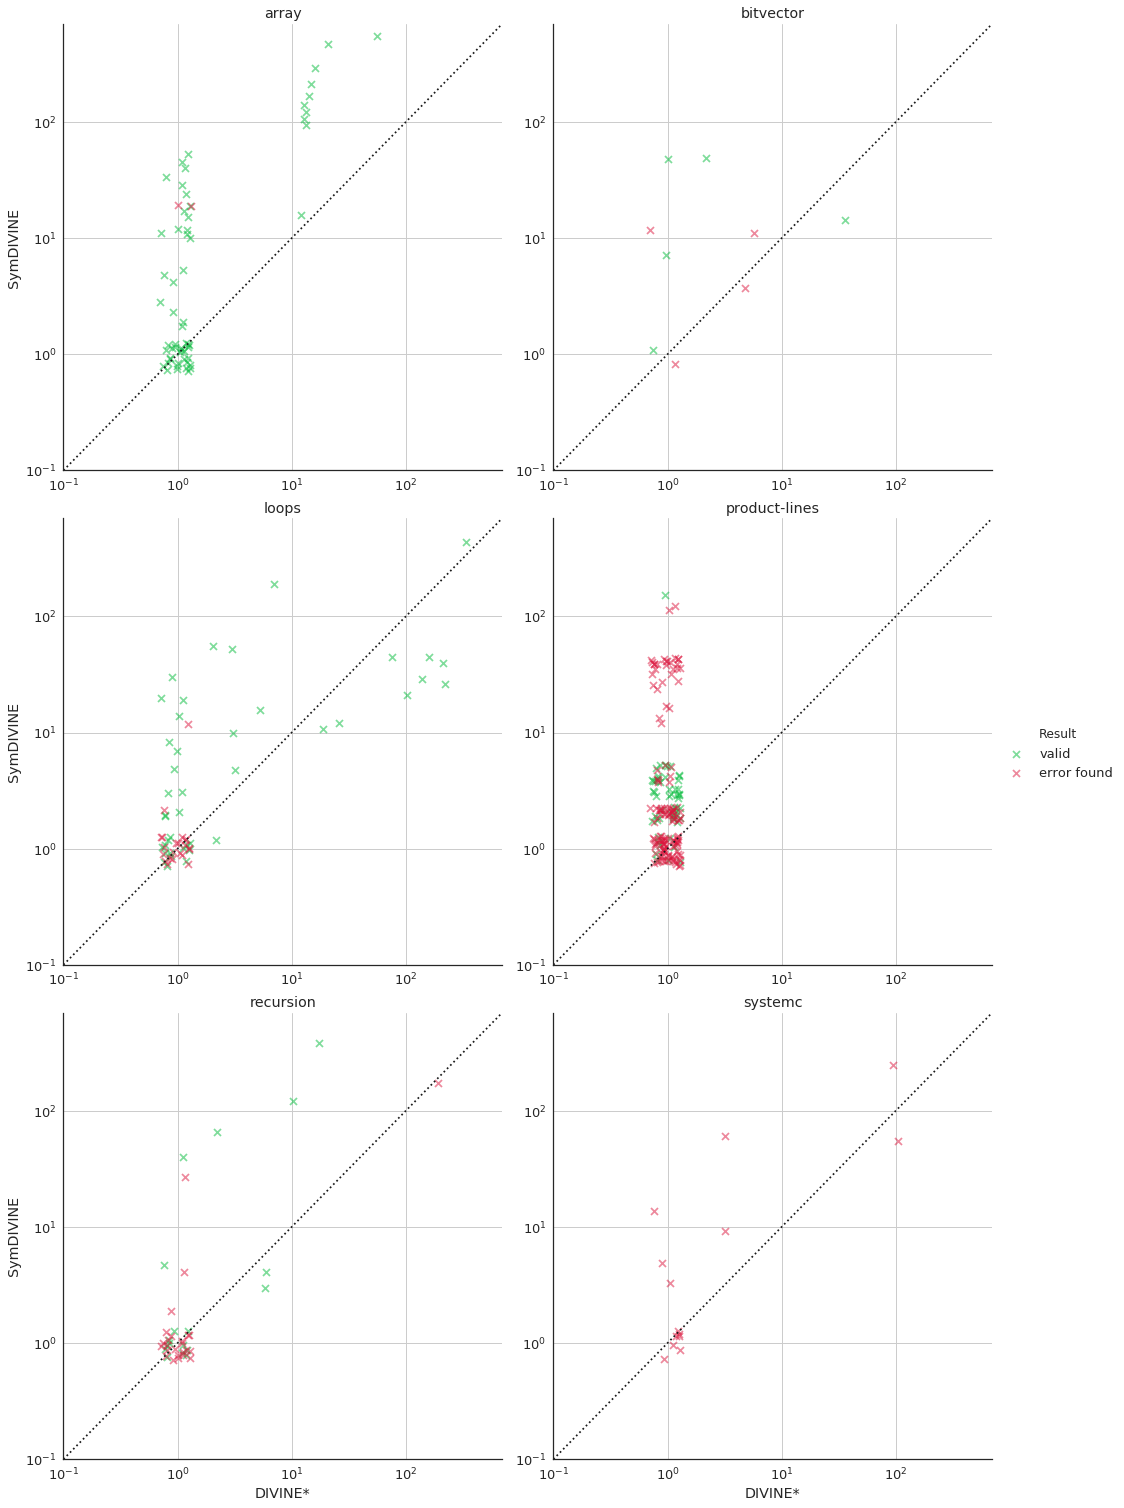

In [8]:
data = pd.merge(div, symdiv, how='inner', left_on=['category','model','variant'], right_on = ['category','model','variant'])
data['DIVINE*'] = data['search_x'].apply(to_seconds).apply( lambda x: 1 if x is 0 else x )
data['SymDIVINE'] = data['search_y'].apply(to_seconds).apply( lambda x: 1 if x is 0 else x )
data['Result'] = data['result_x'].apply( lambda x: 'valid' if x is 'V' else 'error found' )


g = plot_facet_scetter(data,"category", "DIVINE*", "SymDIVINE", "Result", (0.1,700), (0.1,700))
g.savefig("div-sym-time.png")

In [16]:
data.head()

,category,model,variant,result_x,states_x,search_x,ce,correct,result_y,states_y,search_y,DIVINE*,SymDIVINE,Result
0,array,array_monotonic_true.pkg.c,v.10.c,V,115,0:00,0:02,1,V,1895,0:05,1,5,valid
1,array,array_of_struct_break_true.pkg.c,v.10.c,V,21,0:00,0:03,1,V,232,0:00,1,1,valid
2,array,array_of_struct_break_true.pkg.c,v.100.c,V,156,0:01,0:06,1,V,2212,0:12,1,12,valid
3,array,array_ptr_single_elem_init_false.pkg.c,v.10.c,E,3047,0:00,0:07,1,E,14.6 k,0:19,1,19,error found
4,array,array_single_elem_init_false.pkg.c,v.10.c,E,426,0:00,0:05,1,E,14.6 k,0:19,1,19,error found


In [18]:
with open("arrays.txt", "w") as f:
    f.write(data[ data.category == 'array' ]['model'].to_csv())

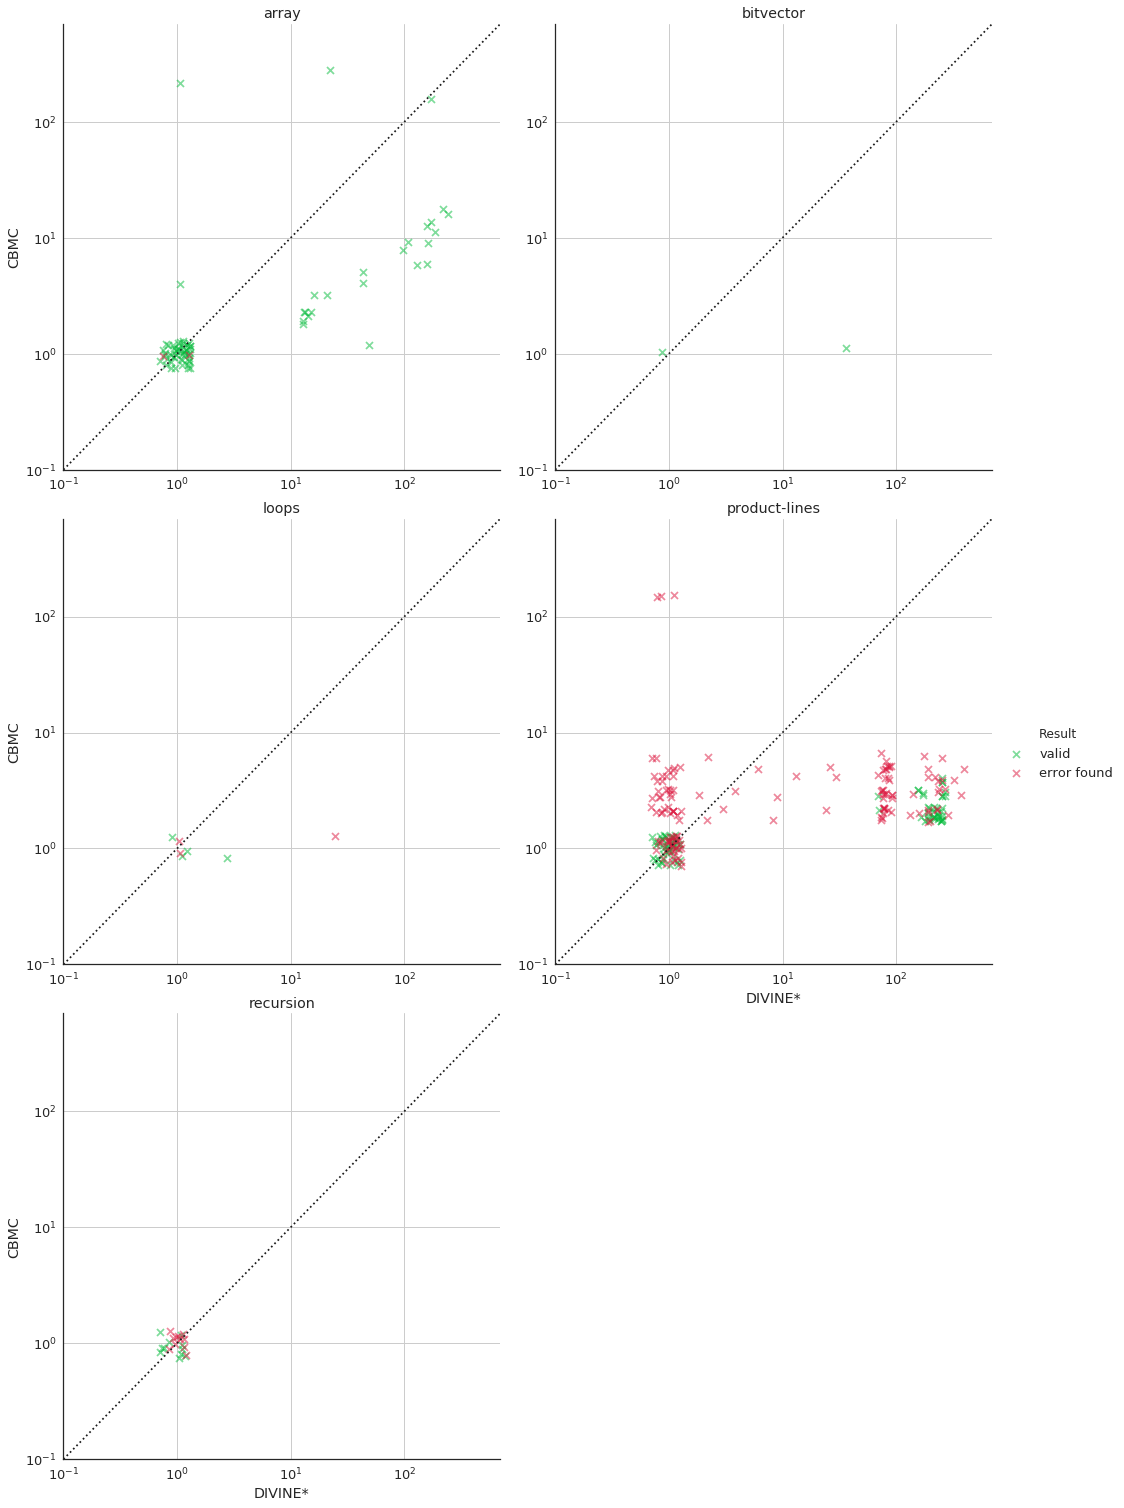

In [41]:
data = pd.merge(div, cbmc, how='inner', left_on=['category','model','variant'], right_on = ['category','model','variant'])

data['DIVINE*'] = data['search_x'].apply(to_seconds).apply( lambda x: 1 if x is 0 else x )
data['CBMC'] = data['search_y'].apply(to_seconds).apply( lambda x: 1 if x is 0 else x )
data['Result'] = data['result_x'].apply( lambda x: 'valid' if x is 'V' else 'error found' )

g = plot_facet_scetter(data,"category", "DIVINE*", "CBMC", "Result", (0.1,700), (0.1,700))
g.savefig("div-cbmc-time.png")

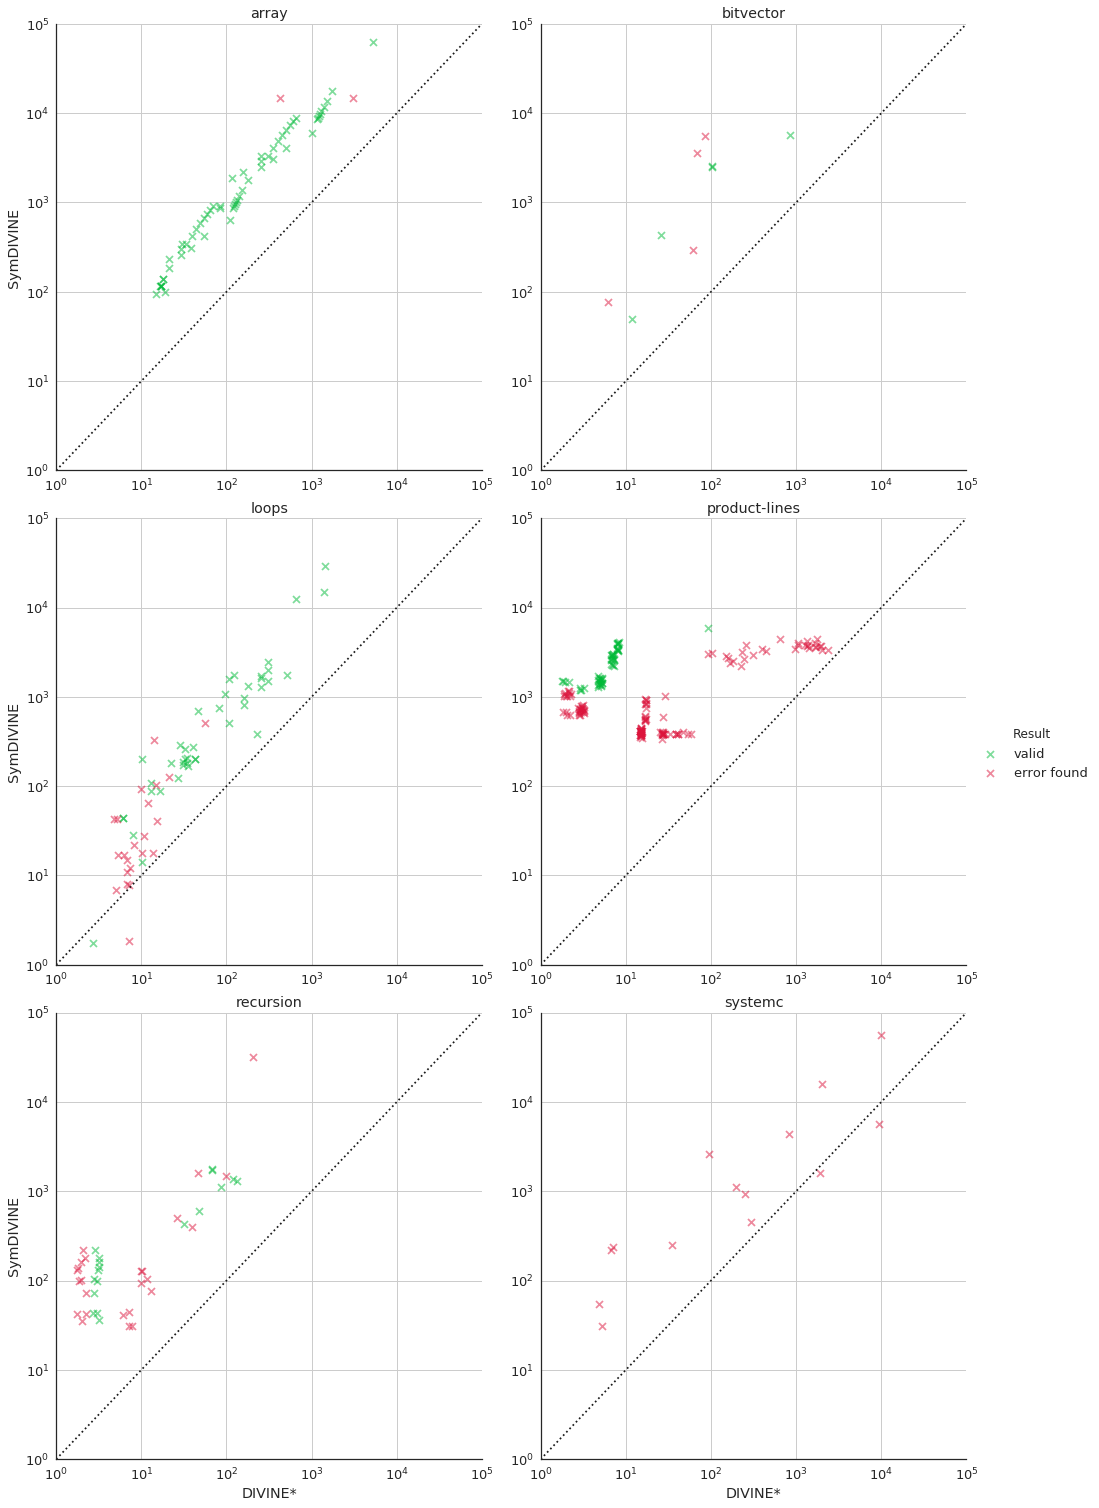

In [42]:
def to_value(x):
    if x.endswith('k'):
        return int(float(x.strip('k')) * 1000)
    elif x.endswith('M'):
        return int(float(x.strip('M')) * 1000000)
    return int(x)

data = pd.merge(div, symdiv, how='inner', left_on=['category','model','variant'], right_on = ['category','model','variant'])
data['DIVINE*'] = data['states_x'].apply( to_value )
data['SymDIVINE'] = data['states_y'].apply( to_value )
data['Result'] = data['result_x'].apply( lambda x: 'valid' if x is 'V' else 'error found' )

g = plot_facet_scetter(data,"category", "DIVINE*", "SymDIVINE", "Result", (1,100000), (1,100000))
g.savefig("div-sym-states.png")